## Loading Required Libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import argparse
import imutils
import cv2


In [2]:
class BoxDetector:
    def __init__(self):
        pass
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        if len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        return shape


In [3]:
#Get countour center cX, cY
def get_contour_center(c, ratio):
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    return cX, cY

In [4]:
# Add text and bounding box to object detected
def annotate_image(cX, cY, cnt, image, ratio,shape): 
    # multiply the contour (x, y)-coordinates by the resize ratio
    # then draw the contours and the name of the shape on the image
    cnt = cnt.astype("float")
    cnt *= ratio
    cnt = cnt.astype("int")
    cv2.drawContours(image, [cnt], -1, (0, 255, 0), 2)
    cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 0, 0), 2)
    cv2.waitKey(0)
    return

In [5]:
#Resize the image to certain width while keeping aspect ratio
def resize_image(image, width):
    # resize the image and resize it to a smaller factor so that
    # the shapes can be approximated better
    resized = imutils.resize(image, width=width)
    ratio = image.shape[0] / float(resized.shape[0])
    return resized, ratio

In [6]:
# Get inverted thresholded image
def get_inverted_binary_threshold(image):
    # convert the resized image to grayscale, blur it slightly,
    # and threshold it
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Adaptive thresholding because the threshold value is different from one image to another 
    # and highly influences the threshold
    thresh = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    # Invert the image
    thresh = 255-thresh 
    return thresh


In [7]:
#Get contours in an image
def find_contours(image):
    # find contours in the thresholded image and initialize the
    # shape detector
    cnts, hierarchy = cv2.findContours(image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours((cnts,hierarchy) )
    return cnts, hierarchy


In [8]:
#Main method for detecting boxes in an image
def detect_boxes(image, sd):
    resized, ratio = resize_image(image, 300)
    thresh = get_inverted_binary_threshold(resized)
    num = 0
    cnts, hierarchy = find_contours(thresh)
    hierarchy = hierarchy[0]
    for i in range(len(cnts)):
        current_cnt = cnts[i]
        current_hie = hierarchy[i]
        shape = sd.detect(current_cnt)
        found = False
        if current_hie[3] < 0 and (shape == "square" or shape == "rectangle"):
            found = True
        elif shape == "square" or shape == "rectangle":
            current_area = cv2.contourArea(current_cnt)
            parent_area = cv2.contourArea(cnts[current_hie[3]])
            area_difference = abs(current_area-parent_area)
            if area_difference >=2000:
                found = True
        if found:
            # shape using only the contour
            cX, cY = get_contour_center(current_cnt, ratio)
            annotate_image(cX, cY, current_cnt, image, ratio, shape)
            num+=1
    return num

## Image Reading and Preprocessing

number of boxes in the first image:  4


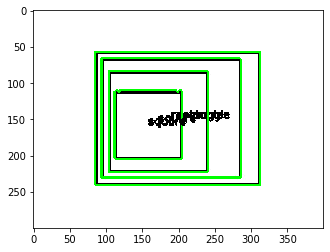

number of boxes in the second image:  16


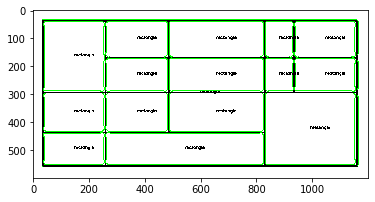

-1

In [9]:
# load the image and resize it to a smaller factor so that
# the shapes can be approximated better
file_name = 'Image_2.png'
image = cv2.imread(file_name)
file_name2 = 'Image_1.png'
image2 = cv2.imread(file_name2)

sd = BoxDetector()
numBoxes = detect_boxes(image, sd)
numBoxes2 = detect_boxes(image2, sd)

print("number of boxes in the first image: ", numBoxes)
plt.imshow(image)
plt.show()
cv2.waitKey(0)

print("number of boxes in the second image: ", numBoxes2)
plt.imshow(image2)
plt.show()
cv2.waitKey(0)


## Conclusion

We can successfully detect nested boxes. For practical purposes, I think this is enough. However, to detect the maximum number of possible boxes we need some programming tricks which I think I would have done if I had more time. I focused on the cv part of this assignment for the sake of scope and the time I had for this task and my thesis.